In [1]:
# Importamos las librerias necesarias
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


## Carga de datos
En la práctica 4 ya realicé la limpieza de datos, por lo que en esta práctica cargaremos el dataset limpio. En la [práctica 4](https://github.com/Luisruimor/practica4_IA) hice dos posibles tratamientos de los valores nulos de la columna "age":

1. Eliminar las filas con valores nulos
2. Imputar los valores mediante el método MICE

En esta práctica vamos a trabajar con el dataset en el que eliminé las columnas con valores nulos, ya que en el método MICE se utiliza la variable que queremos predecir como parte del método de imputación.

In [2]:
# Cargamos el dataset y mostramos las primeras filas
db=pd.read_csv("train_clean_0.csv")
db.head()

,Name,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,"Braund, Mr. Owen Harris",0,3,0,22.0,1,0,7.2500,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,1,38.0,1,0,71.2833,1
2,"Heikkinen, Miss. Laina",1,3,1,26.0,0,0,7.9250,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,1,35.0,1,0,53.1000,0
4,"Allen, Mr. William Henry",0,3,0,35.0,0,0,8.0500,0


## Definición de variable (recordatorio)
- Survived (si sobrevive el pasajero) = 0: Sobrevive, 1: No Sobrevive
- Pclass (la clase en la que se encontraba el pasajero ) = 1: 1a clase, 2: 2a clase, 3: 3a clase
- Sex (indica el sexo)= 0: masculino, 1: femenino
- Age (edad)
- SibSp (indica el número de hermanos, hermanastros, esposo/a que se encontraban a bordo)
- Parch (número total de padres e hijos a bordo)
- Fare (indica la tarifa/precio del ticket)
- Embarked (Indica desde donde zarpo el pasajero) = 0:Southampton ,1:Cherbourg, 2:Queenstown

In [3]:
db.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.365546,29.699118,0.512605,0.431373,34.694514,0.260504
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289,52.918930,0.521012
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,8.050000,0.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000,15.741700,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.375000,0.000000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200,2.000000


## Preprocesamiento del Test Dataset

In [4]:
# Cargamos el dataset de test y mostramos las primeras filas
ExerciseTest=pd.read_csv("test.csv")
db_test = ExerciseTest.copy()
db_test.head()

,Unnamed: 0,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,892,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,F G63,S
1,1,893,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
2,2,894,2,"Aldworth, Mr. Charles Augustus",male,30.0,0,0,248744,13.0000,NaN,S
3,3,895,2,"Andrew, Mr. Frank Thomas",male,25.0,0,0,C.A. 34050,10.5000,NaN,S
4,4,896,2,"Angle, Mr. William A",male,34.0,1,0,226875,26.0000,NaN,S


In [5]:
# Eliminamos las columnas PassengerId, Ticket, Unnamed y Cabin
db_test.drop(['PassengerId','Ticket','Unnamed: 0','Cabin'],axis=1,inplace=True)

# Mapeamos las columnas Embarked y Sex
db_test["Embarked"] = db_test["Embarked"].map({"S": 0, "C": 1, "Q": 2})
db_test["Sex"] = db_test["Sex"].map({"male": 0, "female": 1})

In [6]:
# Calcular % de datos nulos por columna
for col in db_test.columns:
    print(col,":",db_test[col].isnull().sum()/db_test.shape[0]*100,"%")

Pclass : 0.0 %
Name : 0.0 %
Sex : 0.0 %
Age : 20.095693779904305 %
SibSp : 0.0 %
Parch : 0.0 %
Fare : 0.4784688995215311 %
Embarked : 0.0 %


### Procesamiento de los datos nulos
#### Procesamiento de los datos nulos de la columna "Fare"

In [7]:
# Mostrar los valores nulos de la columna Fare
db_test[db_test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
184,3,"Storey, Mr. Thomas",0,60.5,0,0,NaN,0


En el caso de la columna Fare solo hay un elemento nulo por lo que decidí investigar para ver si podía completar la información a mano. En este caso Storey, Mr. Thomas era parte de la tripulación por lo que el Fare es 0.
https://www.encyclopedia-titanica.org/titanic-victim/thomas-storey.html


In [8]:
# Rellenamos el valor nulo con 0
db_test['Fare'].fillna(0,inplace=True)

#### Procesamiento de los datos nulos de la columna "Age"

In [9]:
# Crear un imputador utilizando la estrategia de la mediana
imputer = SimpleImputer(strategy='median')

# Imputar los valores nulos en la columna 'Age'
db_test['Age'] = imputer.fit_transform(db_test[['Age']])

# Verificar que los valores nulos han sido imputados
print(db_test.isnull().sum())

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [10]:
# Calcular % de datos nulos por columna
for col in db_test.columns:
    print(col,":",db_test[col].isnull().sum()/db_test.shape[0]*100,"%")

Pclass : 0.0 %
Name : 0.0 %
Sex : 0.0 %
Age : 0.0 %
SibSp : 0.0 %
Parch : 0.0 %
Fare : 0.0 %
Embarked : 0.0 %


## KNN
El método KNN clasifica datos en función de su similitud con los datos de entrenamiento existentes. La "k" en KNN especifica el nuñemero de vecinos más cercanos que se toman en cuenta para hacer la predicción.
### Preparamos datos

In [11]:
# Eliminamos la columna Name, que no nos aporta información relevante
db.drop('Name',axis=1,inplace=True)
db_test.drop('Name',axis=1,inplace=True)

In [12]:
X = db.drop('Survived',axis=1) # Todas las columnas menos Survived, que es la que queremos predecir
Y = db['Survived'] # La columna que queremos predecir

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Seleccionamos el valor de k
Analizo como se comporta el modelo con diferentes valores de k, y los represento en una gráfica para ver cual es el valor de k que mejor resultado nos da.

([<matplotlib.axis.XTick at 0x27fa1076c80>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

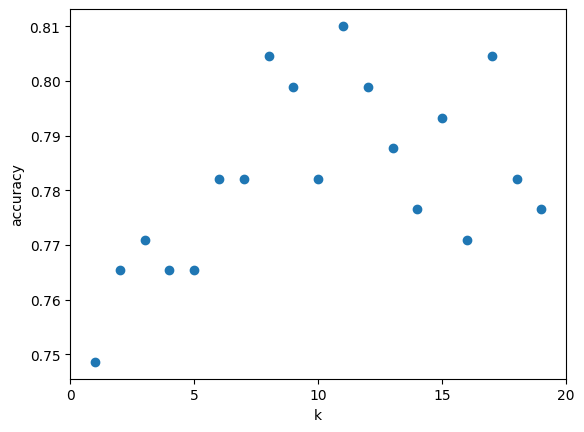

In [13]:
# Probamos con diferentes valores de k
k_range = range(1, 20)
scores = []
for k in k_range:
      knn = KNeighborsClassifier(n_neighbors = k)
      knn.fit(X_train, Y_train)
      scores.append(knn.score(X_test, Y_test))

# Los representamos en una gráfica
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

### Entrenamos el modelo con el valor de k que mejor resultado nos ha dado
Como se ve representado en la gráfica, el valor más alto de precisión del test set se obtiene con k=11, por lo que entreno el modelo con este valor de k.

In [14]:
n_neighbors = 11

# Creamos el modelo
knn = KNeighborsClassifier(n_neighbors)
# Lo entrenamos
knn.fit(X_train, Y_train)

# Imprimimos la precisión del modelo
print('Precisión del modelo en el set de entrenamiento: {:.2f}'
      .format(knn.score(X_train, Y_train)))
print('Precisión del modelo en el set de prueba: {:.2f}'
      .format(knn.score(X_test, Y_test)))

Precisión del modelo en el set de entrenamiento: 0.83
Precisión del modelo en el set de prueba: 0.81


In [15]:
predictSurvive = knn.predict(db_test)

output = pd.DataFrame({'PassengerId': ExerciseTest.PassengerId, 'Survived': predictSurvive })
output.to_csv('test_kaggle.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


c:\Users\Luis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
